# Future climate change
## Simulating the response to different emissions scenarios
### PCS Day 3, Jan. 2022

## Overview:

Here we simulate global mean temperatures under the high-emission RCP8.5 future scenario and two (very) idealised emissions mitigation scenarios. 

In the mitigation scenarios, the anthropogenic RCP8.5 CO2 emissions and non-CO2 radiative forcing (RF) from other gases is multiplied by a factor that decreases from 1 to 0 at a constant rate between two given years. 

Note that scaling the non-CO2 RF rather than non-CO2 emissions amounts to approximating that gases other than CO2 have zero atmospheric lifetime, or that their emissions started to be reduced earlier.

In [1]:
%matplotlib inline

In [2]:
# Basic imports
import numpy as np
from matplotlib import pyplot as plt

In [3]:
import fair

# Check we're using v1.6.1 
print(f"We're using FaIR version {fair.__version__}") 

# The "engine" of fair is fair_scm, stored in the fair.forward class
from fair.forward import fair_scm

We're using FaIR version 1.6.1


# Model set up

In [51]:
def generate_idealized_emissions(year_begin, year_end, baseline_emissions):
    """
    Function to calculate highly-idealized emissions reduction scenarios.
    
    Assumes that anthropogenic RCP8.5 CO2 emissions and non-CO2 radiative forcing (RF) from other gases
    declines linearly from their values at `year_begin` to ZERO at `year_end`.
    """
    idealized_emissions = np.copy(baseline_emissions)
    
    # What reduction per year is required?
    reduction_gradient = idealized_emissions[year_begin-1765, 1:]/(year_end - year_begin)
    
    for idx,year in enumerate(np.arange(year_begin, year_end)):
        
        idealized_emissions[year-1765, 1:] = idealized_emissions[year_begin-1765, 1:]-reduction_gradient*idx 
        
    # After year_end, all emissions=0
    idealized_emissions[year_end-1765:, 1:] = 0.0
    
    return idealized_emissions

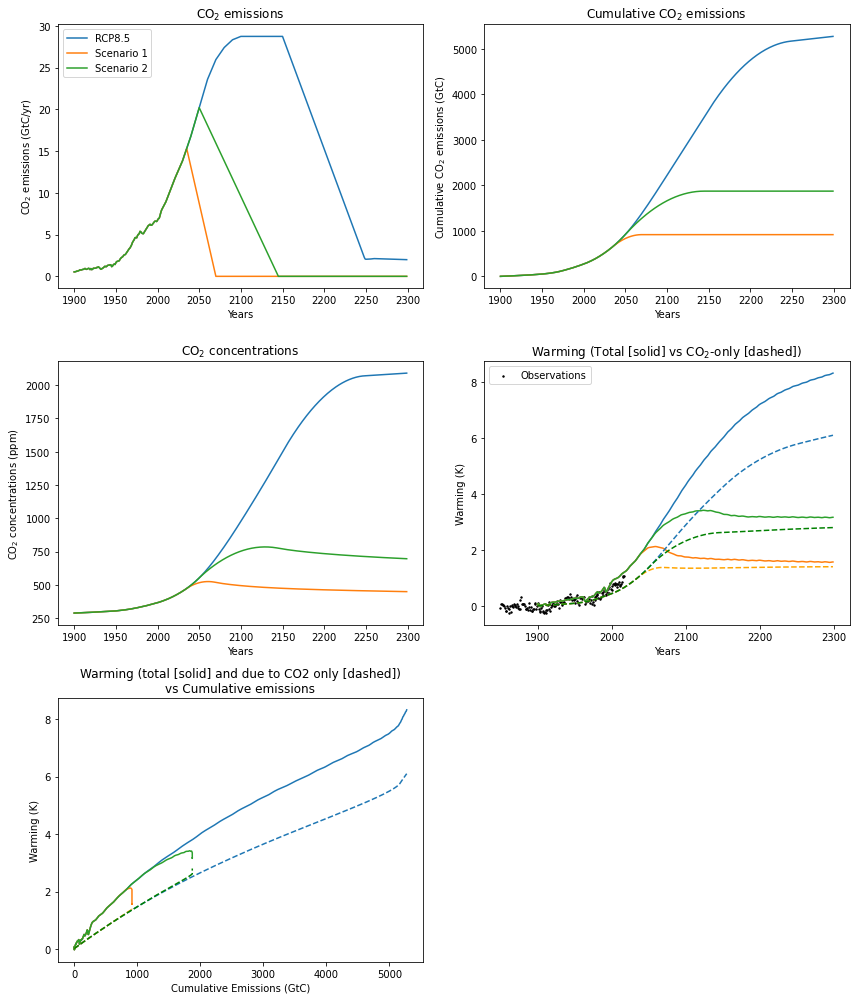

In [100]:
## """Set key model parameters"""
ECS   = 2.7     # equilibrium climate sensitivity (K), default=2.7K, IPCC likely range 1.5-4.5 K
TCR   = 1.6     # transient climate response (K), default=1.6K,      IPCC likely range 1.0-2.5 K

tau_s = 4.1     # ocean mixed layer response time scale (years), default=4.1yrs
tau_d = 239.0   # deep ocean response time scale (years), default=239.0yrs


""" Import RCP8.5, a high-emissions scenario from the IPCC """
from fair.RCPs import rcp85

# Baseline RCP85 model run
C85, F85, T85 = fair_scm(
                emissions=rcp85.Emissions.emissions,                  
                tcrecs=np.array([TCR, ECS]),
                d=np.array([tau_d, tau_s])
)

_,_, T85_co2 = fair_scm(
                emissions=rcp85.Emissions.emissions[:,1],                  
                tcrecs=np.array([TCR, ECS]),
                d=np.array([tau_d, tau_s]),
                useMultigas=False      # Only consider CO2

)


""" Create idealized mitigation pathways """
# Scenario 1
year_begin_reduce_1 = 2035
year_hit_zero_1     = 2070

idealized_emissions_1 = generate_idealized_emissions(year_begin_reduce_1, year_hit_zero_1, rcp85.Emissions.emissions)

# Scenario 2
year_begin_reduce_2 = 2050
year_hit_zero_2     = 2145

idealized_emissions_2 = generate_idealized_emissions(year_begin_reduce_2, year_hit_zero_2, rcp85.Emissions.emissions)

""" Run the model for these idealized scenarios """
Cscen1, Fscen1, Tscen1 = fair_scm(
                emissions=idealized_emissions_1,                  
                tcrecs=np.array([TCR, ECS]),
                d=np.array([tau_d, tau_s])
)

_,_, Tscen1_co2 = fair_scm(
                emissions=idealized_emissions_1[:,1],                  
                tcrecs=np.array([TCR, ECS]),
                d=np.array([tau_d, tau_s]),
                useMultigas=False      # Only consider CO2

)

Cscen2, Fscen2, Tscen2 = fair_scm(
                emissions=idealized_emissions_2,                  
                tcrecs=np.array([TCR, ECS]),
                d=np.array([tau_d, tau_s])
)

_,_, Tscen2_co2 = fair_scm(
                emissions=idealized_emissions_2[:,1],                  
                tcrecs=np.array([TCR, ECS]),
                d=np.array([tau_d, tau_s]),
                useMultigas=False      # Only consider CO2

)


years = rcp85.Emissions.year

""" Plot! """

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 14))

axs[0,0].plot(years[1900-1765:2300-1765], rcp85.Emissions.emissions[:,1][1900-1765:2300-1765], label='RCP8.5')
axs[0,0].plot(years[1900-1765:2300-1765], idealized_emissions_1[:,1][1900-1765:2300-1765], label='Scenario 1')
axs[0,0].plot(years[1900-1765:2300-1765], idealized_emissions_2[:,1][1900-1765:2300-1765], label='Scenario 2')
axs[0,0].set_ylabel("CO$_{2}$ emissions (GtC/yr)")
axs[0,0].legend(loc='upper left')
axs[0,0].set_xlabel('Years')
axs[0,0].set_title("CO$_{2}$ emissions")

axs[0,1].plot(years[1900-1765:2300-1765], np.cumsum(rcp85.Emissions.emissions[:,1][1900-1765:2300-1765]))
axs[0,1].plot(years[1900-1765:2300-1765], np.cumsum(idealized_emissions_1[:,1][1900-1765:2300-1765]))
axs[0,1].plot(years[1900-1765:2300-1765], np.cumsum(idealized_emissions_2[:,1][1900-1765:2300-1765]))
axs[0,1].set_ylabel("Cumulative CO$_{2}$ emissions (GtC)")
axs[0,1].set_xlabel('Years')
axs[0,1].set_title("Cumulative CO$_{2}$ emissions")


axs[1,0].plot(years[1900-1765:2300-1765], C85[:,0][1900-1765:2300-1765])
axs[1,0].plot(years[1900-1765:2300-1765], Cscen1[:,0][1900-1765:2300-1765])
axs[1,0].plot(years[1900-1765:2300-1765], Cscen2[:,0][1900-1765:2300-1765])
axs[1,0].set_ylabel("CO$_{2}$ concentrations (ppm)")
axs[1,0].set_xlabel('Years')
axs[1,0].set_title("CO$_{2}$ concentrations")


#Read in observations, and remove 1861-80 climatology
Y_obs, T_obs = np.genfromtxt("../data/HadCRUT.4.5.0.0.annual_ns_avg.txt")[:,0], np.genfromtxt("../data/HadCRUT.4.5.0.0.annual_ns_avg.txt")[:,1]
i_obs_clm=(1861<=Y_obs) & (Y_obs<=1880)
T_obs=T_obs-np.mean(T_obs[i_obs_clm])
axs[1,1].scatter(Y_obs, T_obs, s=2, color='black', label='Observations')

axs[1,1].plot(years[1900-1765:2300-1765], T85[1900-1765:2300-1765])
axs[1,1].plot(years[1900-1765:2300-1765], Tscen1[1900-1765:2300-1765])
axs[1,1].plot(years[1900-1765:2300-1765], Tscen2[1900-1765:2300-1765])

axs[1,1].plot(years[1900-1765:2300-1765], T85_co2[1900-1765:2300-1765], color='tab:blue', linestyle='dashed')
axs[1,1].plot(years[1900-1765:2300-1765], Tscen1_co2[1900-1765:2300-1765], color='orange', linestyle='dashed')
axs[1,1].plot(years[1900-1765:2300-1765], Tscen2_co2[1900-1765:2300-1765], color='green', linestyle='dashed')


axs[1,1].set_ylabel("Warming (K)")
axs[1,1].set_xlabel('Years')
axs[1,1].set_title("Warming (Total [solid] vs CO$_{2}$-only [dashed])")
axs[1,1].legend()


axs[2,0].plot(np.cumsum(rcp85.Emissions.emissions[:,1][1900-1765:2300-1765]), T85[1900-1765:2300-1765])
axs[2,0].plot(np.cumsum(idealized_emissions_1[:,1][1900-1765:2300-1765]), Tscen1[1900-1765:2300-1765])
axs[2,0].plot(np.cumsum(idealized_emissions_2[:,1][1900-1765:2300-1765]), Tscen2[1900-1765:2300-1765])

axs[2,0].plot(np.cumsum(rcp85.Emissions.emissions[:,1][1900-1765:2300-1765]), T85_co2[1900-1765:2300-1765], color='tab:blue', linestyle='dashed')
axs[2,0].plot(np.cumsum(idealized_emissions_1[:,1][1900-1765:2300-1765]), Tscen1_co2[1900-1765:2300-1765], color='orange', linestyle='dashed')
axs[2,0].plot(np.cumsum(idealized_emissions_2[:,1][1900-1765:2300-1765]), Tscen2_co2[1900-1765:2300-1765], color='green', linestyle='dashed')

axs[2,0].set_title("Warming (total [solid] and due to CO2 only [dashed])\nvs Cumulative emissions")
axs[2,0].set_xlabel("Cumulative Emissions (GtC)")
axs[2,0].set_ylabel("Warming (K)")
axs[2,1].set_axis_off()

fig.tight_layout()

# For the given future scenarios, try to understand the shapes of the different curves shown.

# For the default model parameters, how well do cumulative carbon emissions alone explain the projected total warming for each scenario? 

 - What do you think is the reason for any differences in warming in different scenarios once the same cumulative emissions level has been reached? (Hint – consider the dashed curves, which show the warming due to CO2 only.)

# Increase ECS to 4.5K (the top of the likely range given by the IPCC). 

 - How does this change the relationship between cumulative CO2 emissions and temperature, and why? What are the implications for predicting long-term climate change?